In [3]:
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0

  Using cached https://files.pythonhosted.org/packages/91/2d/2ed263449a078cd9c8a9ba50ebd50123adf1f8cfbea1492f9084169b89d9/tensorboard-1.14.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3c/d5/21860a5b11caf0678fbc8319341b0ae21a07156911132e0e71bffed0510d/tensorflow_estimator-1.14.0-py2.py3-none-any.whl
ERROR: tensorflow 2.1.0 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 2.1.0 has requirement tensorflow-estimator<2.2.0,>=2.1.0rc0, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0


In [4]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
import seaborn as sns
sns.set()

#importint the necessary lirbraries

#import tensorflow.keras as kerasfrom __future__ import print_function

import keras
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam, SGD
from keras import optimizers
from keras.layers import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from os import listdir
import os
from imutils import paths
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
import random

K.set_image_data_format('channels_last')

In [7]:
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [8]:
#define the model
model, eval_model, manipulate_model = CapsNet(input_shape=(28, 28, 1),
                                                  n_class=10,
                                                  routings=3)
model.summary()




Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
___________________________________________

In [9]:
#Now rewriting the algorithm to preprocess about 500 images in my own pipeline
#only do this if you have enough RAM
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir, 0)
        if image is not None:
            image = cv2.resize(image, (28, 28))
            return img_to_array(image)
        else:
            return np.array([])
        
    except Exception as e:
        print(f"Error : {e}")
        return None

image_list = []

directory_root = '../dataset/greyscaled/'
imagePaths = list(paths.list_images(directory_root))
imagePaths = imagePaths[0:-1:2]
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-2] for p in imagePaths]

batch_size = 16
try:
    for i in np.arange(0, len(imagePaths), batch_size):
        batchPaths = imagePaths[i:i + batch_size]
        batchLabels = labels[i: i + batch_size]
        
        for image in batchPaths:
            image_list.append(convert_image_to_array(image))
except Exception as e:
    print(f"Error: {e}")


len(image_list), len(labels)

np_image_list = np.array(image_list, dtype = np.float16) / 255.0
print(f"[INFO] splitting data")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, labels, test_size = 0.2, random_state = 42)

[INFO] splitting data


In [10]:
np_image_list.shape

(9080, 28, 28, 1)

In [11]:
y_test = LabelBinarizer().fit_transform(y_test)
y_train = LabelBinarizer().fit_transform(y_train)

In [12]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train.shape, x_test.shape

((7264, 28, 28, 1), (1816, 28, 28, 1))

In [13]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
x_train.shape, x_test.shape

((7264, 28, 28, 1), (1816, 28, 28, 1))

In [14]:
y_test.shape

(1816, 10)

In [15]:
x_train.shape, len(y_test)
classNames = [str(x) for x in np.unique(labels)]

In [16]:
#fitting the model
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})

weight_path = '../models/best_weights_capsule_new_greyscale.h5'
checkpoint = ModelCheckpoint(weight_path, monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
history = model.fit([x_train, y_train], [y_train, x_train], validation_data = [[x_test, y_test], [y_test, x_test]], epochs = 100, batch_size = 16, callbacks=[checkpoint])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7264 samples, validate on 1816 samples
Epoch 1/100
7264/7264 [==============================] - 252s 35ms/step - loss: 0.8187 - capsnet_loss: 0.8094 - decoder_loss: 0.0237 - capsnet_acc: 0.1598 - val_loss: 0.8187 - val_capsnet_loss: 0.8094 - val_decoder_loss: 0.0236 - val_capsnet_acc: 0.1542

Epoch 00001: val_capsnet_acc improved from -inf to 0.15419, saving model to ../models/best_weights_capsule_new_greyscale.h5
Epoch 2/100
7264/7264 [==============================] - 252s 35ms/step - loss: 0.7063 - capsnet_loss: 0.6973 - decoder_loss: 0.0231 - capsnet_acc: 0.2229 - val_loss: 0.5084 - val_capsnet_loss: 0.4994 - val_decoder_loss: 0.0229 - val_capsnet_acc: 0.3007

Epoch 00002: val_capsnet_acc improved from 0.15419 to 0.30066, saving model to ../models/best_weights_capsule_new_greyscale.h5
Epoch 3/100
7264/7264 [==============================] - 249s 34ms/step - loss: 0.5164 - capsn


Epoch 00020: val_capsnet_acc did not improve from 0.64317
Epoch 21/100
7264/7264 [==============================] - 257s 35ms/step - loss: 0.1200 - capsnet_loss: 0.1145 - decoder_loss: 0.0141 - capsnet_acc: 0.9229 - val_loss: 0.2835 - val_capsnet_loss: 0.2772 - val_decoder_loss: 0.0160 - val_capsnet_acc: 0.6421

Epoch 00021: val_capsnet_acc did not improve from 0.64317
Epoch 22/100
7264/7264 [==============================] - 251s 35ms/step - loss: 0.1057 - capsnet_loss: 0.1002 - decoder_loss: 0.0140 - capsnet_acc: 0.9383 - val_loss: 0.2807 - val_capsnet_loss: 0.2744 - val_decoder_loss: 0.0161 - val_capsnet_acc: 0.6470

Epoch 00022: val_capsnet_acc improved from 0.64317 to 0.64703, saving model to ../models/best_weights_capsule_new_greyscale.h5
Epoch 23/100
7264/7264 [==============================] - 255s 35ms/step - loss: 0.0904 - capsnet_loss: 0.0850 - decoder_loss: 0.0138 - capsnet_acc: 0.9553 - val_loss: 0.2767 - val_capsnet_loss: 0.2703 - val_decoder_loss: 0.0164 - val_capsnet_a

KeyboardInterrupt: 

In [25]:
model.history.history['capsnet_acc']

[0.159829295154185,
 0.22287995594713655,
 0.2678964757709251,
 0.32654185022026433,
 0.4025330396475771,
 0.4772852422907489,
 0.5112885462555066,
 0.5476321585903083,
 0.5664922907488987,
 0.5919603524229075,
 0.6340859030837004,
 0.6584526431718062,
 0.6880506607929515,
 0.7183370044052864,
 0.7509636563876652,
 0.7818006607929515,
 0.8159416299559471,
 0.8386563876651982,
 0.8747246696035242,
 0.8986784140969163,
 0.9229074889867841,
 0.9383259911894273,
 0.9552588105726872,
 0.9648953744493393,
 0.9768722466960352,
 0.9840308370044053,
 0.9885737885462555]

In [18]:
history

import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

#importint the necessary lirbraries

#import tensorflow.keras as kerasfrom __future__ import print_function

import keras
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import tensorflow as tf
from keras import backend as K
from keras

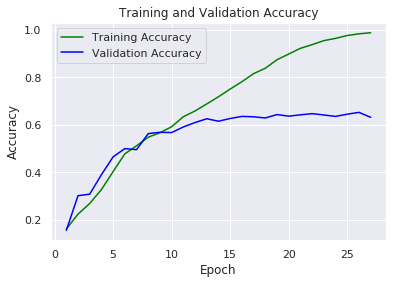

<Figure size 432x288 with 0 Axes>

In [26]:
acc = model.history.history['capsnet_acc']
val_acc = model.history.history['val_capsnet_acc']
loss = model.history.history['capsnet_loss']
val_loss = model.history.history['val_capsnet_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
sns.set()
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('./Plots/Accuracy_Capsulenet_Greyscale.png')
plt.figure()
plt.show()


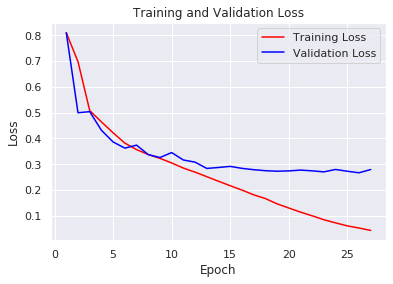

In [28]:
#loss plot
plt.clf()
plt.plot(epochs, loss, color='red', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./Plots/Loss_Capsulenet_Greyscale.png')
plt.show()


In [ ]:
batch_size = 8
base_dir = "../dataset"

train_datagen = ImageDataGenerator(rescale= 1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(base_dir+'/train', target_size=(224,224),batch_size = batch_size, class_mode='categorical')
valid_set = valid_datagen.flow_from_directory(base_dir+'/valid', target_size=(224,224),batch_size = batch_size, class_mode='categorical')


class_dict = training_set.class_indices
li = list(class_dict)

training_num = training_set.samples
valid_num = valid_set.samples

weight_path = '../models/best_weights_capsule_new.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=False, verbose=1)

model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})

model.fit_generator(training_set, steps_per_epoch=training_num//batch_size, epochs=100,validation_data=valid_set, validation_steps=valid_num//batch_size, callbacks=[checkpoint])